<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span><a href="#Импорты-и-константы" data-toc-modified-id="Импорты-и-константы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорты и константы</a></span>
        </li>
        <li>
            <span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span>
            <ul class="toc-item">
                <li>
                    <span><a href="#Вывод-по-EDA" data-toc-modified-id="Вывод-по-EDA-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод по EDA</a></span>
                </li>
            </ul>
        </li>
        <li>
            <span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span>
        </li>
        <li>
            <span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span>
        </li>
        <li>
            <span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span>
        </li>
    </ul>
</div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импорты и константы

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
try:
    df = pd.read_csv('./datasets/taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

In [3]:
RANDOM_STATE = 42

## EDA

In [4]:
def df_info(df):
    print('ОБЩАЯ ИНФОРМАЦИЯ')
    print('----------------')
    df.info()
    print('|' + 100 * '-' + '|')
    print()
    
    print('ПЕРВЫЕ 5 СТРОК ДАТАСЕТА')
    print('-----------------------')
    display(df.head())
    print('|' + 100 * '-' + '|')
    print()
    
    print('КОЛИЧЕСТВО ДУБЛИКАТОВ')
    print('---------------------')
    print(df.duplicated().sum())
    print('|' + 100 * '-' + '|')
    print()
    
    print('ПРОЦЕНТ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ')
    print('--------------------')
    print(df.isna().sum() / df.shape[0] * 100)
    print('|' + 100 * '-' + '|')
    print()
    
    print('КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ')
    print('-----------------------')
    for col in df.select_dtypes(include='object').columns.to_list():
        print(f'-- Уникальные признака {col} --')
        print('-------------------------------')
        print(df[col].unique())
        print()
    print('|' + 100 * '-' + '|')
    print()
      
    print('КОЛИЧЕСТВЕННЫЕ ПРИЗНАКИ')
    print('-----------------------')
    numeric = df.select_dtypes(include='number').columns.to_list()
    if numeric:
        display(df[numeric].describe())
        sns.heatmap(df[numeric].corr(), annot=True, fmt='.2f')

In [5]:
def plot_time_series(df, title=''):
    _, ax = plt.subplots(figsize=(15, 10))
    ax.plot(df)
    ax.set_xlabel('Дата')
    ax.set_ylabel('Количество заказов')
    ax.set_title(title)
    ax.grid(True)
    plt.show()

In [46]:
def research_model(model, params, features, target, metric, cv=5):
    gscv = GridSearchCV(
        model, params, cv=cv,
        scoring=metric,
        n_jobs=-1,
        refit=False,
        return_train_score=True,
        verbose=2
    )
    gscv.fit(features, target)
    result = pd.DataFrame(gscv.cv_results_)
    result['mean_test_score'] *= -1 
    result['mean_train_score'] *= -1
    result.sort_values(by='mean_test_score', inplace=True)
    result.reset_index(drop=True, inplace=True)
    return result

ОБЩАЯ ИНФОРМАЦИЯ
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
|----------------------------------------------------------------------------------------------------|

ПЕРВЫЕ 5 СТРОК ДАТАСЕТА
-----------------------


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


|----------------------------------------------------------------------------------------------------|

КОЛИЧЕСТВО ДУБЛИКАТОВ
---------------------
0
|----------------------------------------------------------------------------------------------------|

ПРОЦЕНТ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
--------------------
datetime      0.0
num_orders    0.0
dtype: float64
|----------------------------------------------------------------------------------------------------|

КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ
-----------------------
-- Уникальные признака datetime --
-------------------------------
['2018-03-01 00:00:00' '2018-03-01 00:10:00' '2018-03-01 00:20:00' ...
 '2018-08-31 23:30:00' '2018-08-31 23:40:00' '2018-08-31 23:50:00']

|----------------------------------------------------------------------------------------------------|

КОЛИЧЕСТВЕННЫЕ ПРИЗНАКИ
-----------------------


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


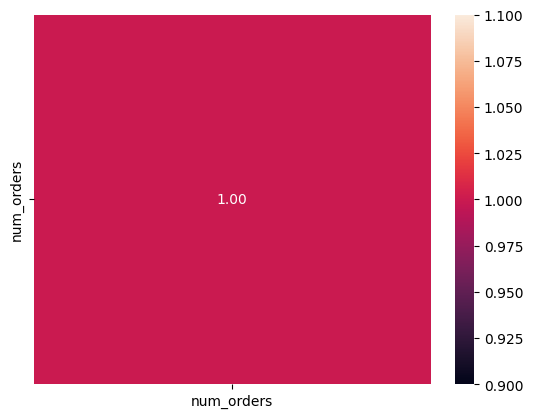

In [7]:
df_info(df)

Датасет содержит в себе 2 колоники:  
1. Дату и время с интервалом в 10 минут  
2. Количество заказов в такси в указанный промежуток времени  
  
Столбец с датой и временем назначим индексом датасета. Стоит заметить, что в датасете нет пропуском и дубликатов

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [9]:
df.set_index('datetime', inplace=True)

In [10]:
df.index.is_monotonic_increasing

True

Индексы расположены в хронологическом порядке

In [11]:
print(f'Самая ранняя дата - {df.index.min()}')
print(f'Самая поздняя дата - {df.index.max()}')

Самая ранняя дата - 2018-03-01 00:00:00
Самая поздняя дата - 2018-08-31 23:50:00


В датасете нам дана информация с 3 марта 2018 года по 31 августа 2018 года, то есть за 6 месяцев

Произведем ресемплирование данный. Сгрупперуем данные по 1 часу и посчитаем общее количество заказов за этот час

In [12]:
df = df.resample('1H').sum()

C:\Users\a_a_k\AppData\Local\Temp\ipykernel_10832\1649191478.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum()


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


Количество заказов распределено межно 0 и 462. Среднее количество заказов - `84.4`, медиана - `78`

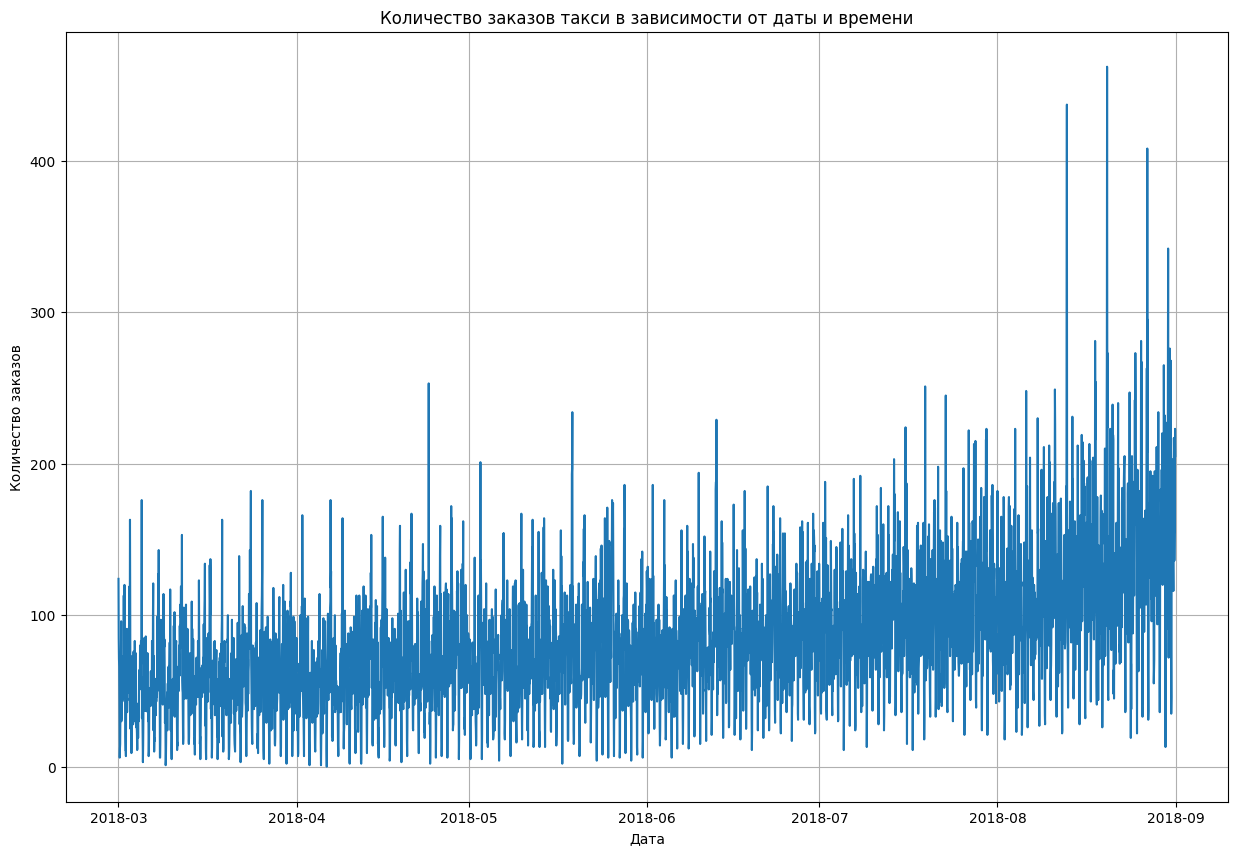

In [14]:
plot_time_series(df, 'Количество заказов такси в зависимости от даты и времени')

Попробуем сгладить временной ряд

<Axes: xlabel='datetime'>

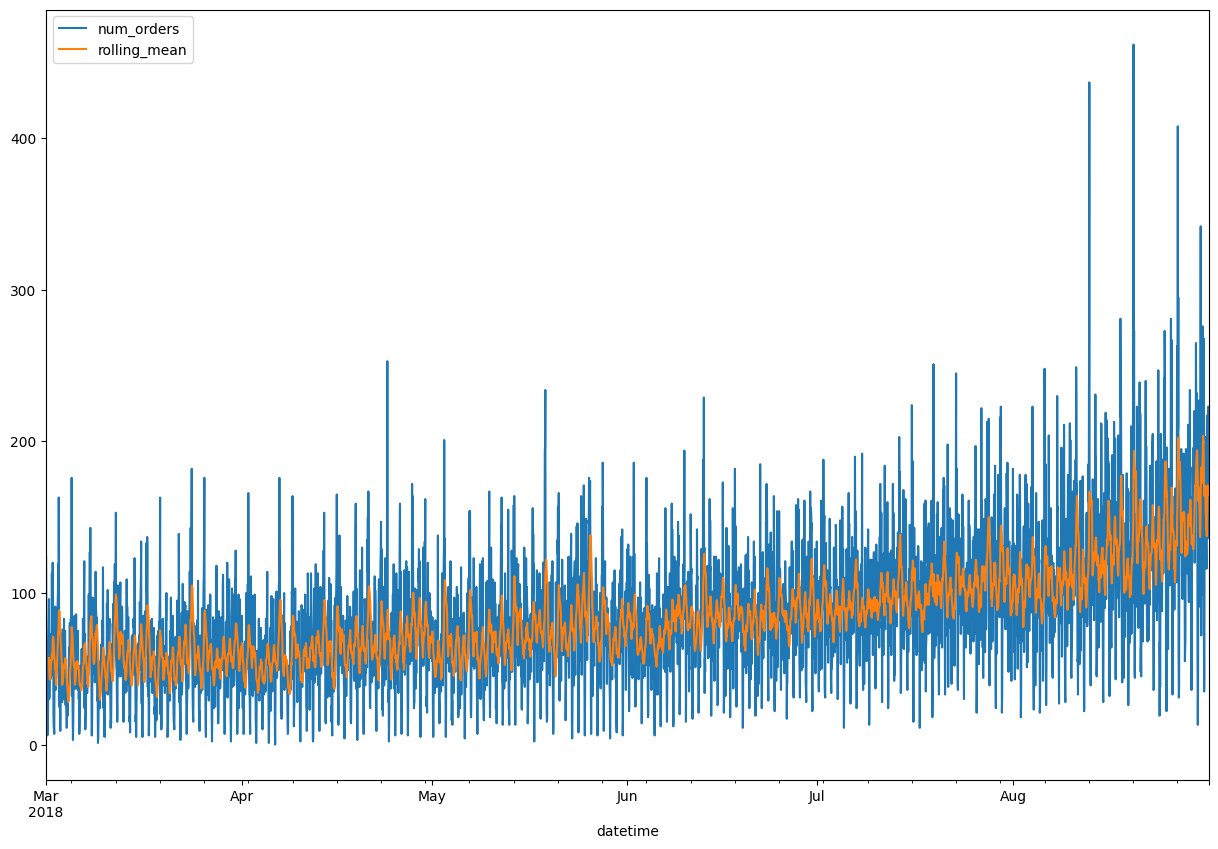

In [15]:
df['rolling_mean'] = df.rolling(12).mean()
df.plot(figsize=(15,10))

Наблюдается общий тренд увеличения заказов такси с марта по август. Выделим тренд и сезонность временного ряда

In [16]:
df.drop('rolling_mean', axis=1, inplace=True)

In [17]:
decomposed = seasonal_decompose(df['num_orders'])

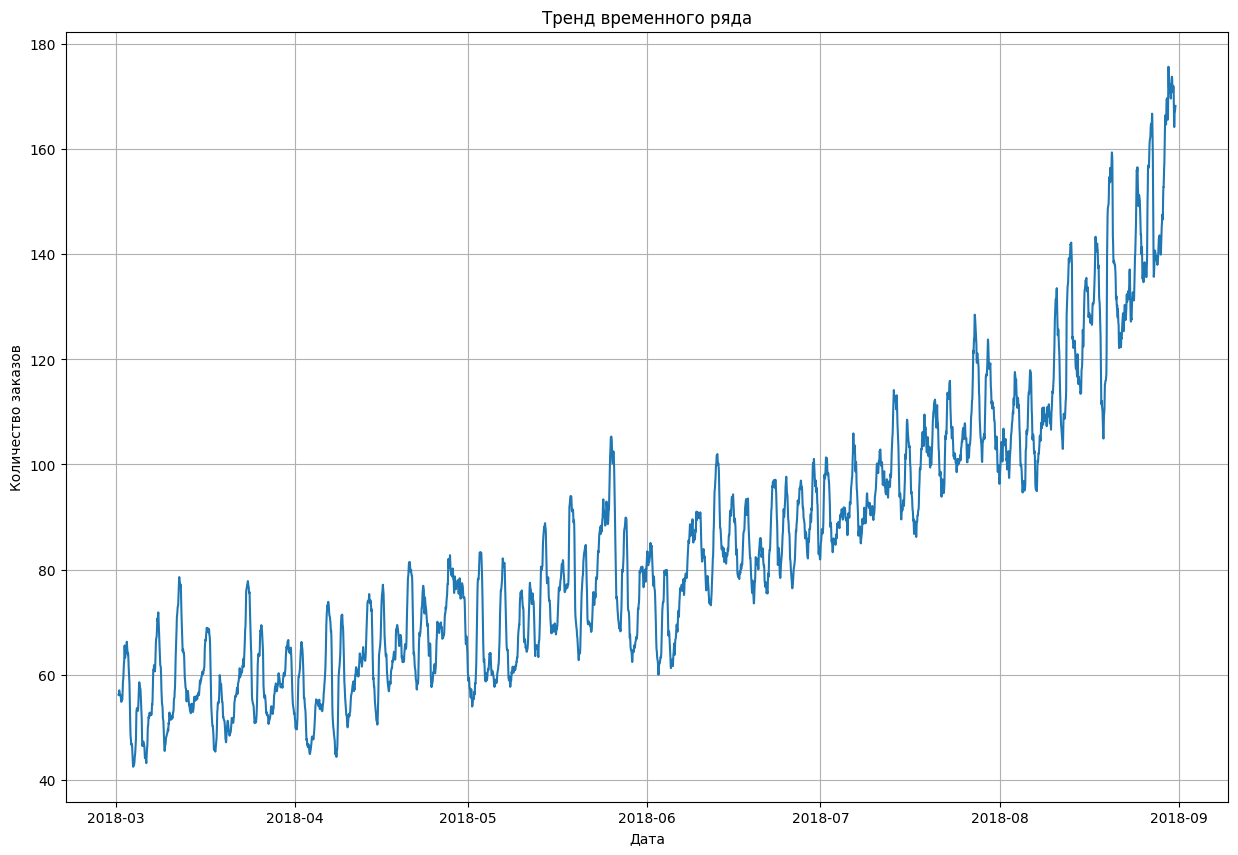

In [18]:
plot_time_series(decomposed.trend, 'Тренд временного ряда')

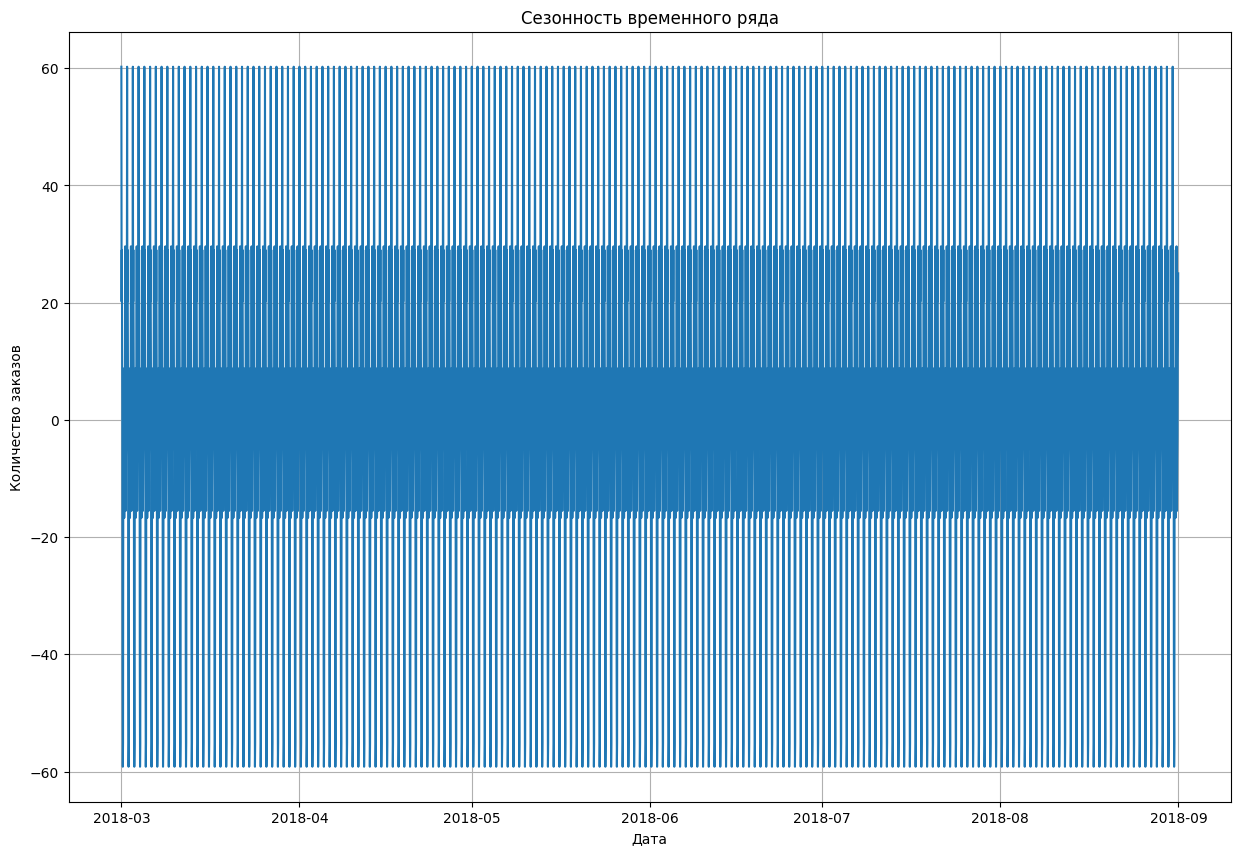

In [19]:
plot_time_series(decomposed.seasonal, 'Сезонность временного ряда')

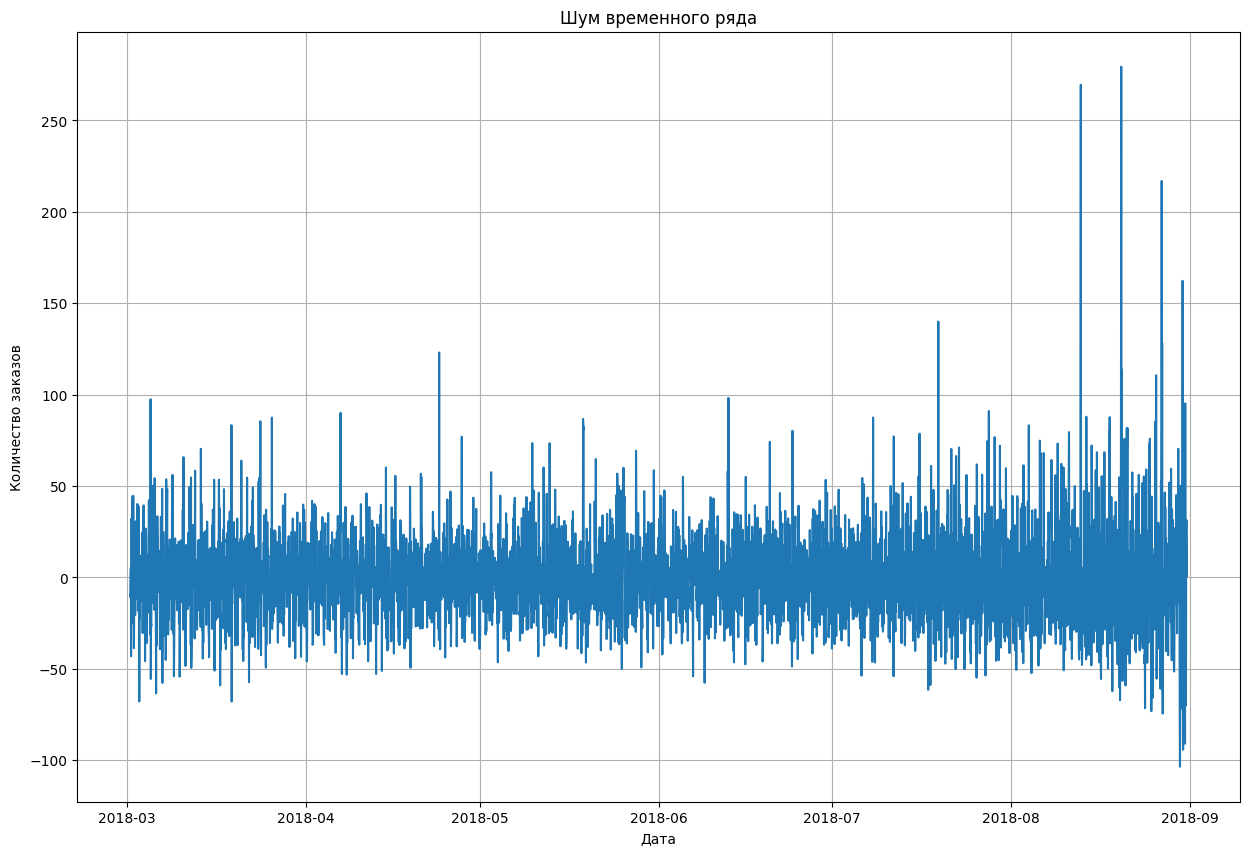

In [20]:
plot_time_series(decomposed.resid, 'Шум временного ряда')

По графику трендо действительно наблюдается увеличение количества заказов с марта по август. График шума временного ряда показывает, что в выборе присутствуют достаточно сильные выбросы. Причем в июле и августе выбросов становится больше. В текущем масштабе график сезонности является не информативным. Для более детального изучения возьмем промежуток за неделю

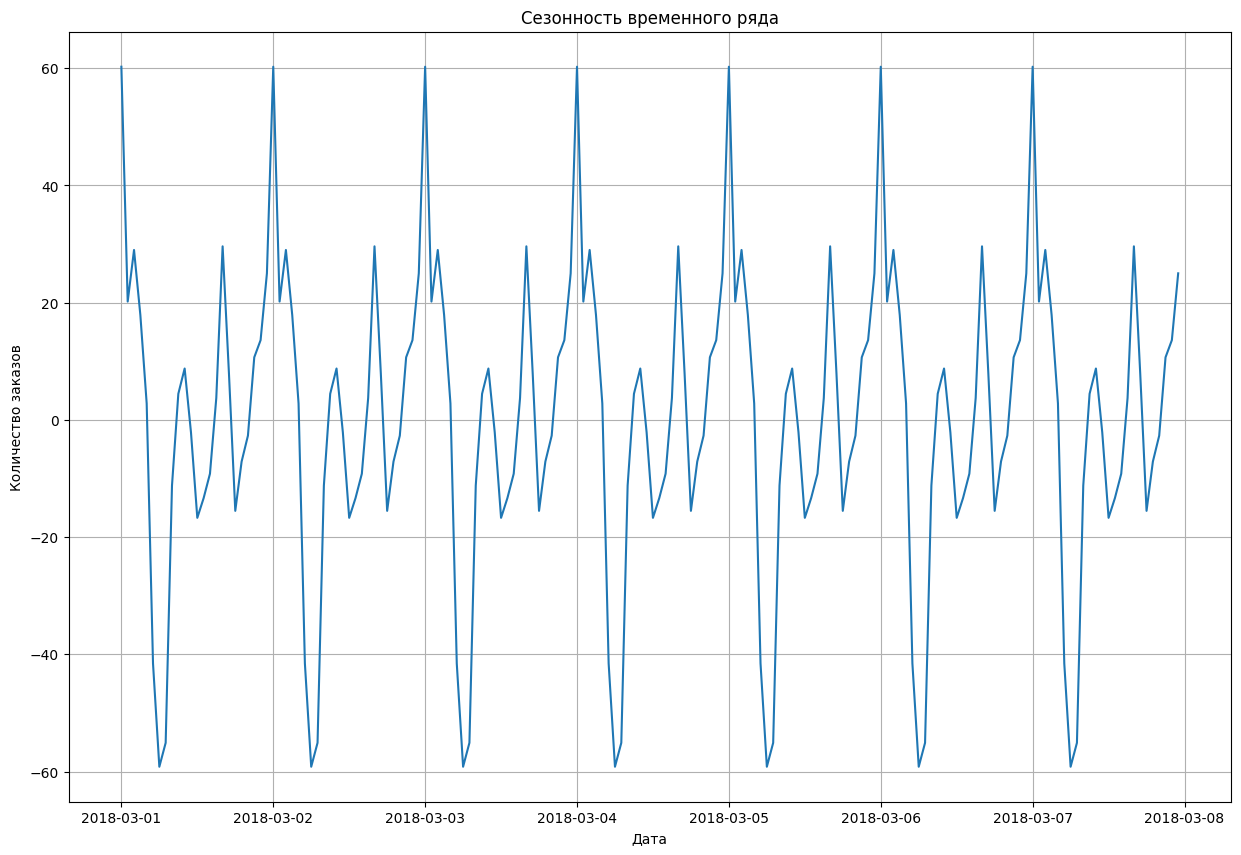

In [21]:
plot_time_series(decomposed.seasonal['2018-03-01':'2018-03-07'], 'Сезонность временного ряда')

По графику видно, что период сезонности - 1 день, поэтому посмотрим график сезонности за 1 день

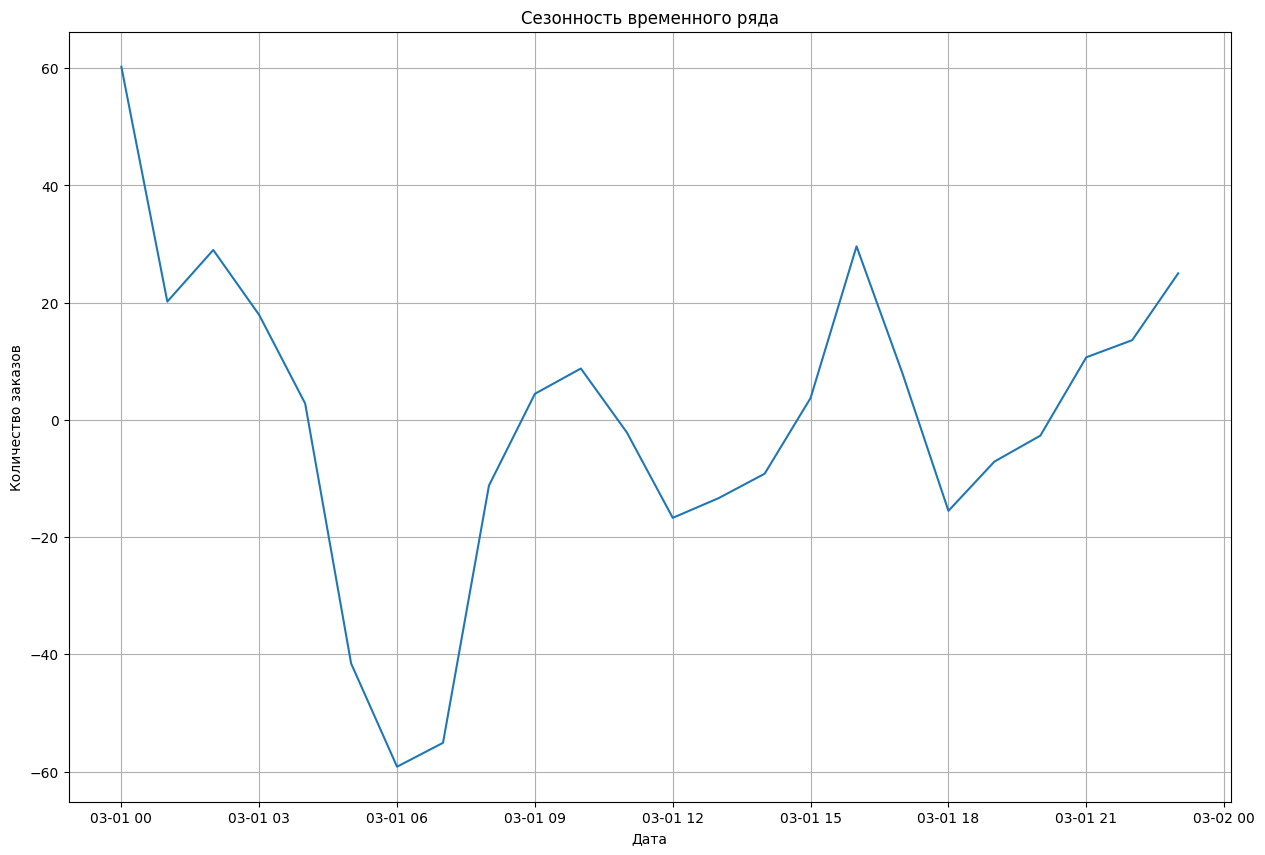

In [22]:
plot_time_series(decomposed.seasonal['2018-03-01'], 'Сезонность временного ряда')

Видно, что в вечернее и ночное время количество заказов растет. Это может быть обусловлено тем, что в это время общественный транспорт ходит хуже и люди возвращаются домой на такси. Утром (с 4 до 8 утра) количество заказов наоборот падает, что обусловлено тем, что большинство людей еще спят в это время, либо толко встают и начинают собираться на работу.

Также попробуем сгруппировать данные по дням и посмотреть, будет ли недельная сезонность

In [23]:
df_days = df.resample('1D').sum()

In [24]:
decomposed_days = seasonal_decompose(df_days['num_orders'])

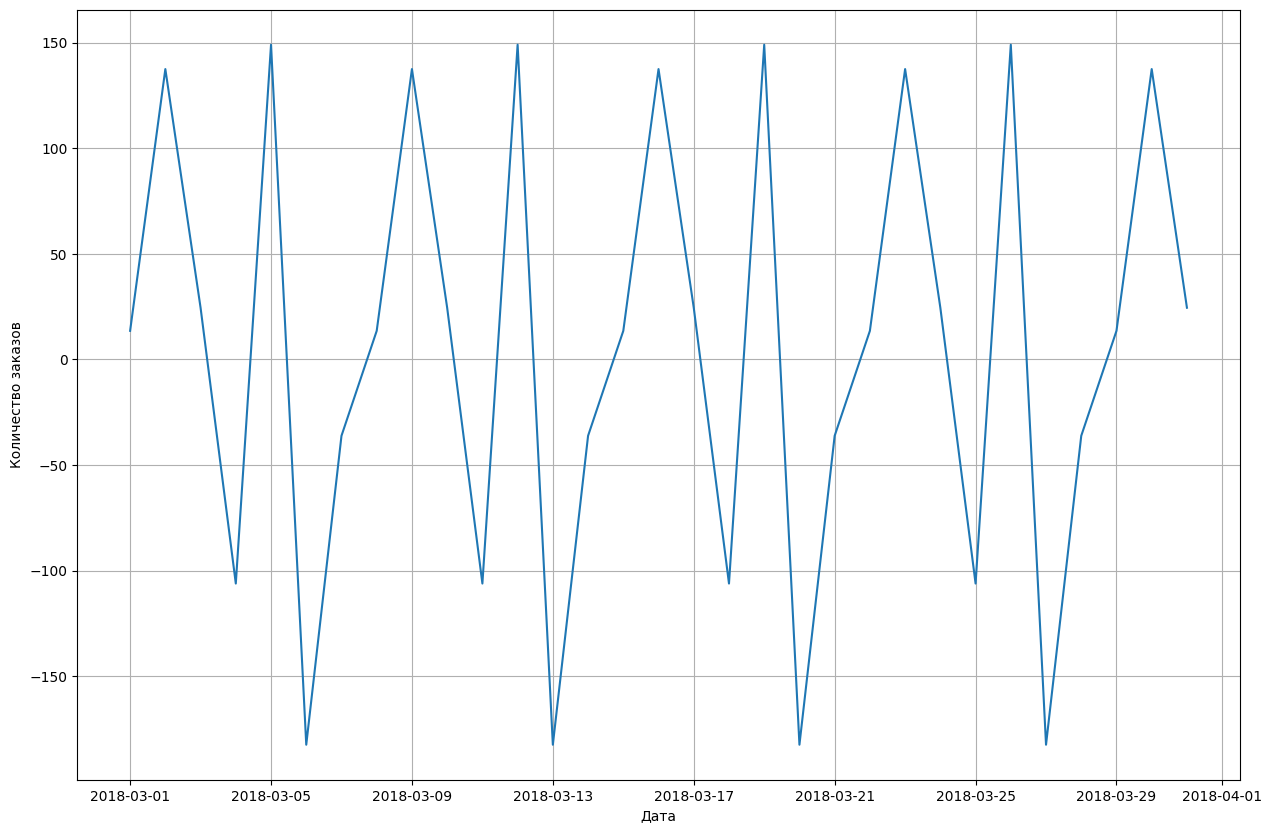

In [25]:
plot_time_series(decomposed_days.seasonal['2018-03-01':'2018-03-31'])

In [26]:
df_days['weekday'] = df_days.index.dayofweek
df_days['2018-03-05':'2018-03-11']

,num_orders,weekday
datetime,,
2018-03-05,1259,0
2018-03-06,1109,1
2018-03-07,1441,2
2018-03-08,1659,3
2018-03-09,1076,4
2018-03-10,1267,5
2018-03-11,1600,6


По недельной сезонности можно заметить значительное увеличение заказов такси в понедельк и пятницу. Возможно, это связано с тем, что люди не хотят после выходных ехать на работу на общественном транспорте, а в пятницу стремятся отдохнуть и воздно возвращаются. В выходные и остальные рабочие дни количество заказов такси значительно уменьшается

In [27]:
del df_days
del decomposed_days

Проверим ряд на стационарность. Для этого посчитаем среднее и стандартное отклонение по окну размер в 24(за сутки)

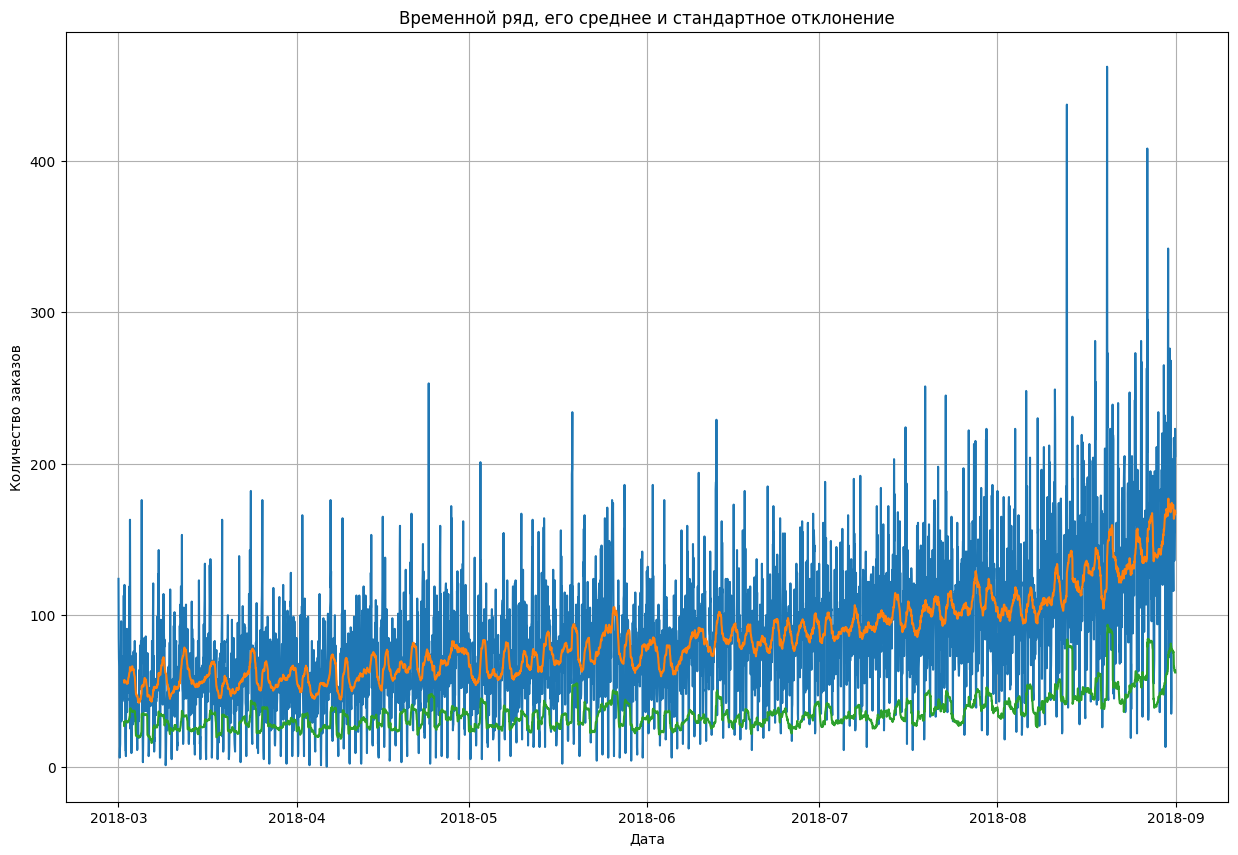

In [28]:
df['mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
plot_time_series(df, 'Временной ряд, его среднее и стандартное отклонение')

Ряд не является стационарным, так как у него меняется и среднее, и стандартное отклонение.

In [29]:
df.drop(['mean', 'std'], axis=1, inplace=True)

### Вывод по EDA

В ходе исследовательского анализа данных датасет, содержащий временной ряд с количеством заказов такси. В датасете нет пропусков и дубликатов. Временной индекс является монотонным. Было проведено ресемлировние временного ряда с новым периодом в 1 час. Временной ряд был разложен на тренд, показывающий рост количества заказов с марта по август и сезонность с периодом в 1 день. Также можно заметить, что временной ряд не является стационарным, так как его среднее и стандартное отклонение не являются постоянными.

## Обучение

В качестве календарных признаков будет использовать месяц, день, день недели, час

In [30]:
def prepare_data(df, max_lag, rolling_mean_size, test_size=.15):
    '''
    Функиця для подготовки данных. Создает признаки для обучения
    и возвращает тренировочную и тестовую выборки.
    Параметры:
    df - датасет
    max_lag - максимальное смещение
    rolling_mean_size - размер скользяцего окна для вычисления среднего
    test_size - процент тестовоой выборки
    Возвращает: признаки и целевые переменные для тренировочной и тестовой
    выборок
    '''
    df = pd.DataFrame(df.copy())
    df.columns = ['y']
    
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for i in range(max_lag):
        df[f'lag_{i}'] = df['y'].shift(i)
        
    df['rolling_mean'] = df['y'].shift(1).rolling(rolling_mean_size).mean()
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return train_test_split(
        df.drop('y', axis=1), df['y'], test_size=test_size,
        shuffle=False, random_state=RANDOM_STATE
    )
    

In [31]:
X_train, X_test, y_train, y_test = prepare_data(df, 5, 10, .15)
print(X_train.shape[0])
print(X_test.shape[0])

3745
661


В нашей задаче имеется 2 типа гиперпараметров:  
1. Гимерпараметры временного ряда (максимальное смещение, размер скользящего окна)  
2. Гимерпараметры модели  
  
Для исключения ручного подбора гиперпараметров будем использовать GridSearchCV для подбора гиперпараметров модели и цикл for для подбора гиперпараметров временного ряда.

In [54]:
max_lag_arr = range(3, 25, 3)
rolling_mean_size_arr = range(6, 25, 3)

In [47]:
X_train, X_test, y_train, y_test = prepare_data(df, 5, 10, .15)
cv = TimeSeriesSplit(n_splits=5)
gscv_config_rand_forest = {
    'max_depth': range(1, 3),
    'n_estimators': range(1, 21, 5),
}
model_rand_forest = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
result = research_model(
    model_rand_forest, gscv_config_rand_forest,
    X_train, y_train,
    metric='neg_root_mean_squared_error', cv=cv
)
result[['params', 'mean_train_score', 'mean_test_score']].head(3)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,params,mean_train_score,mean_test_score
0,"{'max_depth': 2, 'n_estimators': 16}",9.711068,12.055417
1,"{'max_depth': 2, 'n_estimators': 11}",9.725386,12.071112
2,"{'max_depth': 2, 'n_estimators': 6}",9.713032,12.130689


In [56]:
random_forest_best_param = pd.DataFrame(columns=['mean_train_score', 'mean_test_score', 'model_params', 'ts_params'])
for max_lag in max_lag_arr:
    for rolling_mean_size in rolling_mean_size_arr:
        print(f'__________max_lag={max_lag}_rolling_mean_size={rolling_mean_size}__________')
        ts_params = {
            'max_lag': max_lag,
            'rolling_mean_size': rolling_mean_size
        }
        X_train, X_test, y_train, y_test = prepare_data(df, max_lag, rolling_mean_size, .15)
        ts_cv = TimeSeriesSplit(n_splits=5)
        gscv_config_rand_forest = {
            'max_depth': range(1, 11),
            'n_estimators': range(1, 202, 5),
        }
        model_rand_forest = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
        result = research_model(
            model_rand_forest, gscv_config_rand_forest,
            X_train, y_train,
            metric='neg_root_mean_squared_error', cv=ts_cv
        )
        random_forest_best_param.loc[len(random_forest_best_param)] = [
            result.loc[0, 'mean_train_score'],
            result.loc[0, 'mean_test_score'],
            result.loc[0, 'params'],
            ts_params,
        ]
random_forest_best_param.sort_values(by='mean_test_score', inplace=True)
random_forest_best_param.reset_index(drop=True, inplace=True)
random_forest_best_param.head()

__________max_lag=3_rolling_mean_size=6__________
Fitting 5 folds for each of 410 candidates, totalling 2050 fits


KeyboardInterrupt: 

## Тестирование

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48